## This notebook
1. 5-fold cross validation with optuna for hyperparameter tuning
2. n_model ensemble prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#sklearn libraries
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

#models
from lightgbm import LGBMRegressor

#pandas
import pandas as pd
import numpy as np

#optimization
import optuna

#ploting lib
import plotly.express as px

#python libraries
import pickle
import json

In [5]:
class CONFIG:
    numeric_features= ["no_units","area","unit_price","sale_month","sale_year", "tenure_yrs"]
    categorical_features = ['type','post_district','market_segment',
                            'type_sale','type_area','floor_level', 'sale_month']
    n_splits = 10

In [3]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 54.4 MB/s 
     |████████████████████████████████| 80 kB 7.5 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 47.3 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 149 kB 31.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7fe51c6ca426a9207f262a95bfe7bdff378a6aa52c9d738cf49b7d83ea6d39fc
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## Data preparation

In [6]:
preprocessed_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/pr_processed_df.csv", index_col=0)
preprocessed_data= preprocessed_data.drop_duplicates()
preprocessed_data = preprocessed_data.sample(frac=1)
preprocessed_data = preprocessed_data.drop(['S/N','Nett Price ($)', 'Project Name', 'Street Name'], axis=1).reset_index(drop=True)
preprocessed_data.columns=['type', 'post_district', 'market_segment', 'type_sale', 
                           'no_units', 'price', 'area', 'type_area', 'floor_level', 'unit_price','sale_month', 'sale_year', 'tenure_yrs']
preprocessed_data.head()

,type,post_district,market_segment,type_sale,no_units,price,area,type_area,floor_level,unit_price,sale_month,sale_year,tenure_yrs
0,Apartment,15,OCR,New Sale,1.0,1582000.0,786.0,Strata,21 to 25,2013.0,11,2017,94
1,Condominium,27,OCR,Resale,1.0,820000.0,764.0,Strata,01 to 05,1073.0,11,2018,89
2,Condominium,21,OCR,New Sale,1.0,2178000.0,1173.0,Strata,01 to 05,1856.0,7,2021,863
3,Condominium,8,RCR,Sub Sale,1.0,810000.0,420.0,Strata,11 to 15,1930.0,10,2021,93
4,Apartment,11,CCR,Resale,1.0,2610000.0,1238.0,Strata,16 to 20,2108.0,11,2019,999999


In [19]:
preprocessed_data

,type,post_district,market_segment,type_sale,no_units,price,area,type_area,floor_level,unit_price,sale_month,sale_year,tenure_yrs
0,Apartment,15,OCR,Resale,1.0,1750000.0,2099.0,Strata,01 to 05,834.0,5,2018,999999
1,Apartment,23,OCR,Resale,36.0,42600000.0,34746.0,Strata,01 to 05,1226.0,7,2019,47
2,Condominium,14,OCR,Resale,1.0,1205640.0,1130.0,Strata,01 to 05,1067.0,7,2018,88
3,Condominium,23,OCR,Resale,1.0,955000.0,1432.0,Strata,06 to 10,667.0,2,2017,74
4,Condominium,10,CCR,Resale,1.0,3500000.0,1948.0,Strata,11 to 15,1796.0,5,2021,999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103878,Apartment,5,RCR,New Sale,1.0,1186871.0,689.0,Strata,11 to 15,1723.0,1,2021,97
103879,Condominium,19,OCR,Resale,1.0,930000.0,624.0,Strata,01 to 05,1490.0,1,2021,999999
103880,Condominium,21,OCR,New Sale,1.0,1311000.0,743.0,Strata,01 to 05,1765.0,7,2021,863
103881,Apartment,19,OCR,Resale,1.0,2280000.0,2077.0,Strata,01 to 05,1097.0,5,2021,999999


In [7]:
features = preprocessed_data.drop("price", axis=1)
target = preprocessed_data["price"]
display(features.shape)
display(target.shape)

(103883, 12)

(103883,)

## Model
We are going to wrap all the construction into optuna objective

In [11]:
def get_model(model_args):
    #numeric_transformer
    numeric_transformer = Pipeline(steps=[
        ("normalize", StandardScaler()),
        ("polyfeatures", PolynomialFeatures())
    ])

    #categorical_transformer
    categorical_transformer = Pipeline(steps=[
        ("encoding", OneHotEncoder(drop='first'))
    ])


    # Column transformer
    preprocessing = ColumnTransformer(transformers=[
        ('numerical_columns', numeric_transformer, CONFIG.numeric_features),
        ("categorical_column", categorical_transformer, CONFIG.categorical_features)
    ])

    #model definition and optuna suggestions
    #following the documentation at https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html, we will
    #be tuning 3 important hyperparameters 1. num_leaves 2. min_data_in_leaf  3. max_depth
    
    model = LGBMRegressor(**model_args)

    # main pipeline
    full_model_pipeline = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("clf", model)
    ])
    
    return full_model_pipeline


In [9]:
def objective(trial):
    num_leaves = trial.suggest_int("num_leaves",19,25,step=2)
    n_estimators = trial.suggest_int("n_estimators",2000,6000, step=100)
#     min_data_in_leaf  = trial.suggest_int("min_data_in_leaf",100,2000, step=250)
#     max_depth = trial.suggest_int("max_depth",7,13,step=2)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01,0.3)
    
    model_args={'num_leaves': num_leaves, 
                'n_estimators': n_estimators, 
                'max_depth': -1, 
                'learning_rate': learning_rate,
                "metric" : "rmse"}
    
    full_model_pipeline = get_model(model_args)
    
    mape = -1.0* np.mean(cross_val_score(full_model_pipeline,features,target,cv=5,scoring='neg_root_mean_squared_error'))
    
    return mape

In [23]:
study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=35)

[I 2021-12-10 23:13:31,738] A new study created in memory with name: no-name-0ba93fb2-4b57-4793-91f4-aeb2659ea05e
[I 2021-12-10 23:17:09,656] Trial 0 finished with value: 5011476.050936179 and parameters: {'num_leaves': 25, 'n_estimators': 3600, 'learning_rate': 0.018465536802445528}. Best is trial 0 with value: 5011476.050936179.
[I 2021-12-10 23:22:56,621] Trial 1 finished with value: 5078207.139934768 and parameters: {'num_leaves': 25, 'n_estimators': 5900, 'learning_rate': 0.01933119288010828}. Best is trial 0 with value: 5011476.050936179.
[I 2021-12-10 23:25:19,570] Trial 2 finished with value: 5416540.715627869 and parameters: {'num_leaves': 25, 'n_estimators': 2400, 'learning_rate': 0.08608200177168131}. Best is trial 0 with value: 5011476.050936179.
[I 2021-12-10 23:30:45,922] Trial 3 finished with value: 5975377.212562981 and parameters: {'num_leaves': 25, 'n_estimators': 5800, 'learning_rate': 0.14108714745118175}. Best is trial 0 with value: 5011476.050936179.
[I 2021-12-10

In [24]:
print(study.best_trial)

FrozenTrial(number=28, values=[4718437.041094746], datetime_start=datetime.datetime(2021, 12, 11, 1, 1, 22, 774453), datetime_complete=datetime.datetime(2021, 12, 11, 1, 3, 26, 312420), params={'num_leaves': 21, 'n_estimators': 2000, 'learning_rate': 0.013685035585904524}, distributions={'num_leaves': IntUniformDistribution(high=25, low=19, step=2), 'n_estimators': IntUniformDistribution(high=6000, low=2000, step=100), 'learning_rate': LogUniformDistribution(high=0.3, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=28, state=TrialState.COMPLETE, value=None)


## Ensembling model based on best params
{'num_leaves': 23, 'n_estimators': 5400, 'learning_rate': 0.09069317714796007}

parameters: {'num_leaves': 23, 'n_estimators': 3800, 'learning_rate': 0.010121367377342328}

params={'num_leaves': 21, 'n_estimators': 2000, 'learning_rate': 0.013685035585904524}

In [ ]:
print(study.best_trial)

### Testing the performance of 1 model

In [12]:
best_params = {'num_leaves': 23, 'n_estimators': 5400, 'learning_rate': 0.09069317714796007}
full_model_pipeline = get_model(best_params)

X_train, X_text, y_train, y_test = train_test_split(features, target, train_size=0.9, random_state=42)
full_model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_columns',
                                                  Pipeline(steps=[('normalize',
                                                                   StandardScaler()),
                                                                  ('polyfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['no_units', 'area',
                                                   'unit_price', 'sale_month',
                                                   'sale_year', 'tenure_yrs']),
                                                 ('categorical_column',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['type', 'post_district'

In [13]:
y_pred = full_model_pipeline.predict(X_text)

In [59]:
px.scatter(x=y_pred,y=y_test,title="Actual vs. Prediction")

In [30]:
pd.Series(y_pred)

0        2.163752e+06
1        1.697557e+06
2        3.709450e+06
3        7.771547e+05
4        2.045991e+06
             ...     
10383    8.117422e+05
10384    3.965707e+06
10385    2.961796e+06
10386    2.386364e+06
10387    9.361542e+05
Length: 10388, dtype: float64

0.96726992683866

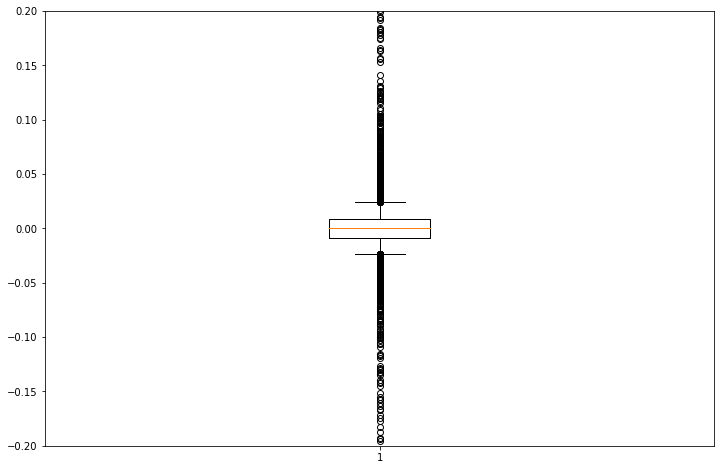

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
comp_df = pd.concat([y_test.reset_index()['price'], pd.Series(y_pred)], axis=1).rename(columns={'price':'Actual', 0:'Predicted'})
comp_df.head()
comp_df.loc[:, 'Normal_Error'] = (comp_df['Predicted']-comp_df['Actual'])/comp_df['Actual']
plt.figure(figsize=(12,8))
# ax = sns.boxplot(x ='Normal_Error', data=comp_df)
plt.boxplot(comp_df['Normal_Error'], whis=[5,95])
plt.ylim(-0.2, 0.2)
# display(comp_df['Normal_Error'].describe())
# ax.set_xscale('log')

display(comp_df[abs(comp_df['Normal_Error'])<=0.05].shape[0]/comp_df.shape[0])

## Ensembling 10 models with 10 fold cv
As we can see from above, the housing cost is not evenly distributed and therefore, we are going create a stratifiedKfold for continuous variable

In [15]:
class ContinuousStratifiedKFold(StratifiedKFold):
    #using parent init
    def split(self,X,y,groups=None):
        #using the same signature as original
        n_bins = 8
        bins = pd.cut(y, bins=n_bins, labels=False)
        return super().split(X,bins,groups=groups)

In [17]:
fold_splitter = ContinuousStratifiedKFold(n_splits=CONFIG.n_splits,shuffle=True, random_state=42)

result_log = {}
y_test_log = []
y_pred_log = []

for n_fold, (train_idx,test_idx) in enumerate(fold_splitter.split(features, target)):
    print(f"Training fold:{n_fold}")
    X_train=features.iloc[train_idx]
    y_train = target.iloc[train_idx]
    
    X_test = features.iloc[test_idx]
    y_test = target.iloc[test_idx]
    y_test_log.append(y_test)
    
    model_pipeline = get_model(best_params)
    model_pipeline.fit(X_train,y_train)
    y_pred = model_pipeline.predict(X_test)
    y_pred_log.append(y_pred)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test,y_pred)
    
    result_dict = dict(rmse=rmse, mae=mae, mape=mape)
    print(result_dict)
    result_log[n_fold] = result_dict
    
    #saving model
    model_dir = f"/content/drive/My Drive/Colab Notebooks/model_pipeline_fold_{n_fold}.pkl"
    with open(model_dir, 'wb') as pklfile:
        pickle.dump(model_pipeline, pklfile, protocol=pickle.HIGHEST_PROTOCOL)
        print("Model saved")
     

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=10.



Training fold:0
{'rmse': 5636453.38428517, 'mae': 172065.85694039814, 'mape': 0.036736320721795154}
Model saved
Training fold:1
{'rmse': 6141657.711063038, 'mae': 192339.52082502635, 'mape': 0.028638375134514307}
Model saved
Training fold:2
{'rmse': 1866896.9570361453, 'mae': 88820.14274840787, 'mape': 0.02434728089592826}
Model saved
Training fold:3
{'rmse': 709912.2062127297, 'mae': 54078.475174390325, 'mape': 0.025327850654414084}
Model saved
Training fold:4
{'rmse': 4285946.516956127, 'mae': 160641.5670238263, 'mape': 0.02740743069551763}
Model saved
Training fold:5
{'rmse': 2889387.1884849453, 'mae': 102321.35870127489, 'mape': 0.02770758442079095}
Model saved
Training fold:6
{'rmse': 5048299.7295647245, 'mae': 132803.5623038837, 'mape': 0.01804713608316737}
Model saved
Training fold:7
{'rmse': 7879022.388023287, 'mae': 184907.1800654644, 'mape': 0.019382909463832993}
Model saved
Training fold:8
{'rmse': 4598846.174442554, 'mae': 139393.89395626687, 'mape': 0.02286436103103448}
Mo

In [18]:
## saving results
with open("/content/drive/My Drive/Colab Notebooks//metrics_result.json", 'w') as jsonfile:
    json.dump(result_log, jsonfile)